In [8]:
import sys
!{sys.executable} -m pip install wfdb
import wfdb

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 48.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  You can safely remove it manually.


In [11]:
!{sys.executable} -m pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 76.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.5 MB/s eta 0:00:00


In [14]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import welch
import wfdb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set global variables
fs = 200  # Sampling rate (Hz)
epoch_length = 30 * fs  # 6000 samples = 30 seconds
timesteps = 10  # LSTM timesteps
record_ids = ['tr03-0005', 'tr03-0029','tr03-0052', 'tr03-0061', 'tr03-0078','tr03-0079','tr03-0083','tr03-0086']

# Mapping stages
stage_mapping = {
    "W": "Wake",
    "N1": "N1",
    "N2": "N2",
    "N3": "N3",
    "R": "REM",
    "REM": "REM"
}

# PSD feature extractor
def compute_psd_features(signal):
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    delta = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
    theta = np.sum(psd[(freqs >= 4) & (freqs < 8)])
    alpha = np.sum(psd[(freqs >= 8) & (freqs < 12)])
    sigma = np.sum(psd[(freqs >= 12) & (freqs < 14)])
    return [delta, theta, alpha, sigma]

# Load and extract features
samples = []
labels = []

for record_id in record_ids:
    try:
        print(f"Processing {record_id}...")
        data = loadmat(f"{record_id}.mat")
        eeg_signal = data['val'][2, :]  # Adjust channel index if needed

        annotation = wfdb.rdann(record_id, "arousal")

        for i, timestamp in enumerate(annotation.sample):
            raw_label = annotation.aux_note[i]
            clean_label = next((stage_mapping[stage] for stage in stage_mapping if stage in raw_label.split()), None)
            if not clean_label:
                continue

            start = timestamp
            end = min(timestamp + epoch_length, len(eeg_signal))
            eeg_epoch = eeg_signal[start:end]
            if len(eeg_epoch) != epoch_length or not np.isfinite(eeg_epoch).any():
                continue

            # Break 30-second epoch into smaller time windows for LSTM
            step_len = epoch_length // timesteps
            features = []
            for j in range(0, epoch_length, step_len):
                segment = eeg_epoch[j:j + step_len]
                if len(segment) == step_len:
                    features.append(compute_psd_features(segment))

            if len(features) == timesteps:
                samples.append(features)
                labels.append(clean_label)

    except Exception as e:
        print(f"⚠️ Error processing {record_id}: {e}")

# Convert to numpy arrays
X = np.array(samples)
le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

print(f"LSTM input shape: {X.shape}")
print(f"Classes: {le.classes_}")


Processing tr03-0005...
Processing tr03-0029...
Processing tr03-0052...
Processing tr03-0061...
Processing tr03-0078...
Processing tr03-0079...
Processing tr03-0083...
Processing tr03-0086...
LSTM input shape: (958, 10, 4)
Classes: ['N1' 'N2' 'N3' 'REM' 'Wake']


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


E0000 00:00:1745254229.462263 2520178 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745254229.467522 2520178 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/salaza7/.conda/envs/cpsc-4300/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2367 - loss: 1.5733 - val_accuracy: 0.3896 - val_loss: 1.3830
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4744 - loss: 1.2951 - val_accuracy: 0.4026 - val_loss: 1.3396
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4952 - loss: 1.2281 - val_accuracy: 0.3961 - val_loss: 1.2985
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5450 - loss: 1.1447 - val_accuracy: 0.3961 - val_loss: 1.2608
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5245 - loss: 1.0845 - val_accuracy: 0.3831 - val_loss: 1.2404
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5415 - loss: 1.0955 - val_accuracy: 0.4286 - val_loss: 1.1944
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5424 - loss: 1.0533 - val_accuracy: 0.4545 - val_loss: 1.1693
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5771 - loss: 1.0283 - val_accuracy: 0.5260 - v

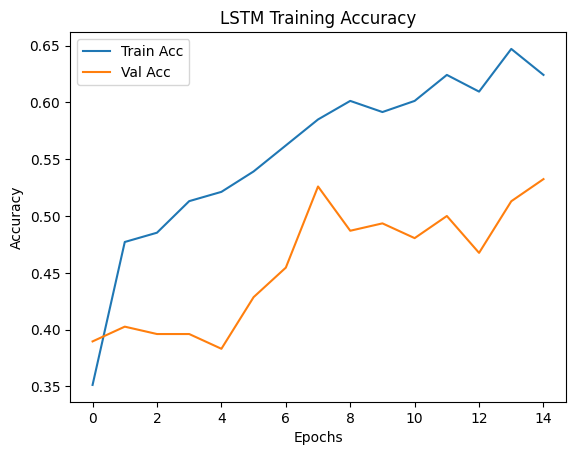

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training Accuracy')
plt.show()


In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.5677
📉 Test Loss: 1.0038


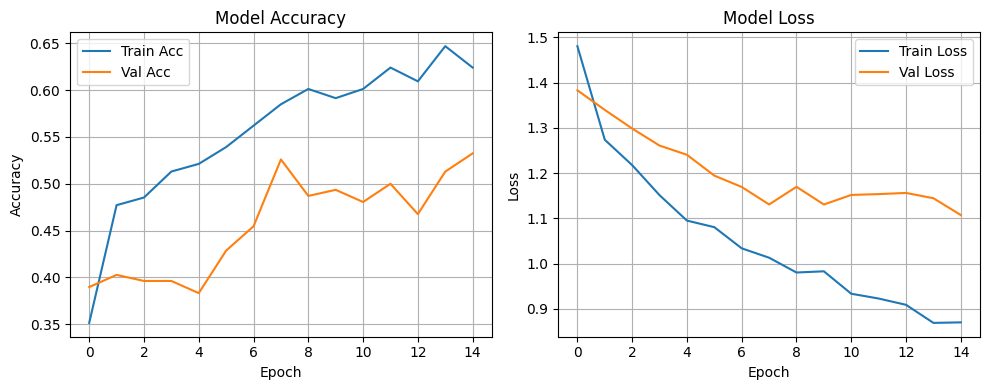

In [18]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
import numpy as np

# Predict probabilities and get class predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


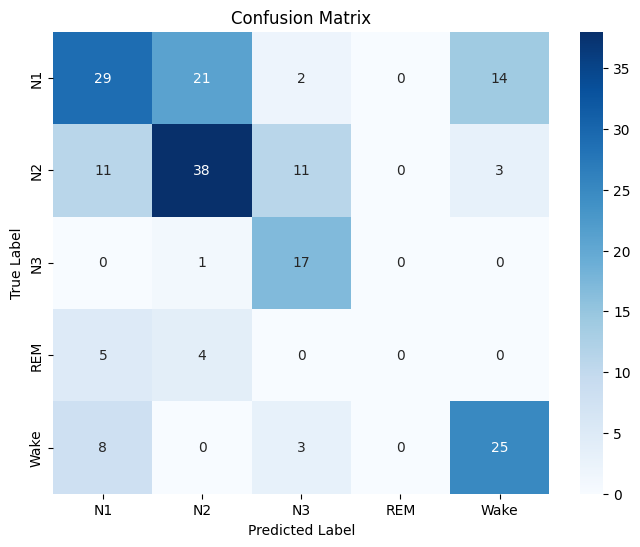

📋 Classification Report:

              precision    recall  f1-score   support

          N1       0.55      0.44      0.49        66
          N2       0.59      0.60      0.60        63
          N3       0.52      0.94      0.67        18
         REM       0.00      0.00      0.00         9
        Wake       0.60      0.69      0.64        36

    accuracy                           0.57       192
   macro avg       0.45      0.54      0.48       192
weighted avg       0.54      0.57      0.55       192



/home/salaza7/.conda/envs/cpsc-4300/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/salaza7/.conda/envs/cpsc-4300/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/salaza7/.conda/envs/cpsc-4300/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


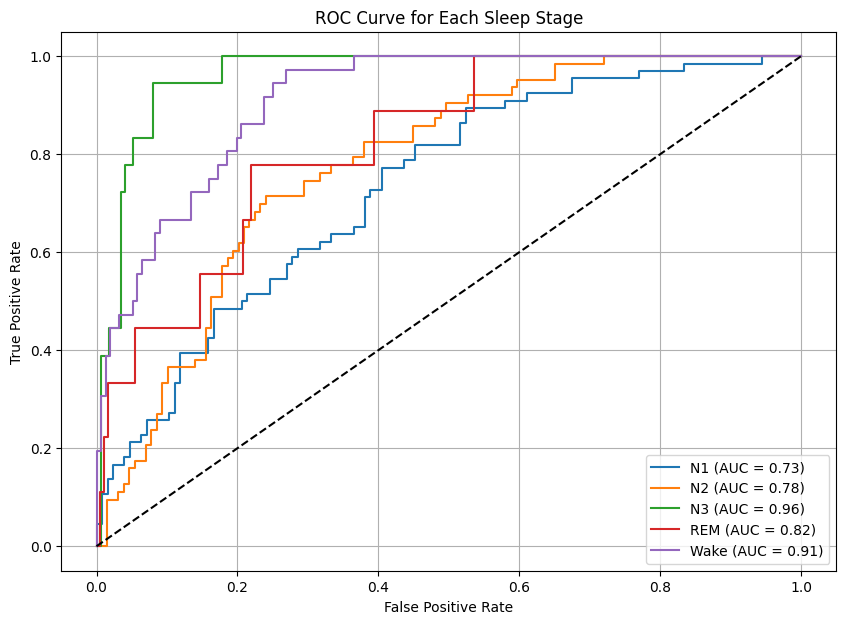

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize again if needed
y_test_bin = y_test
n_classes = y_test.shape[1]

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Sleep Stage")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
